In [1]:
import math
import numpy as np
from numpy import sqrt, exp, pi, power, tanh
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [2]:
# time constants: Postnova et al. 2018 - Table 1
tau_v = 50 #s
tau_m = tau_v
tau_H = 59*3600 #s
tau_X = (24*3600) / (2*pi) #s
tau_Y = tau_X
tau_C = 24.2*3600 #s

In [3]:
# coupling strengths constants: Postnova et al. 2018 - Table 1
nu_vm = -2.1 #mV
nu_mv = -1.8 #mV
nu_Hm = 4.57 #s
nu_Xp = 37*60 #s
nu_Xn = 0.032
nu_YY = (1/3)*nu_Xp #???? OK seems
nu_YX = 0.55*nu_Xp
nu_vH = 1
nu_vC = -0.5 #mV

In [4]:
# external neuronal drives constants: Postnova et al. 2018 - Table 1
A_v = -10.3 #mV
D_m = 1.3 #mV
A_m = D_m

In [5]:
# circadian constants: Postnova et al. 2018 - Table 1
gamma = 0.13
delta = 24*3600/0.99729 #s
beta = 0.007/60 #sˆ-1

In [6]:
# nonphotic drive constant: Postnova et al. 2018 - Table 1
r = 10

In [7]:
# photic drive constants: Postnova et al. 2018 - Table 1
epsilon = 0.4
I_0 = 100 #lx
I_1 = 9500 #lx
alpha_0 = 0.1/60 #sˆ-1

In [8]:
# firing rate constants: Postnova et al. 2018 - Table 1
Q_max = 100 #sˆ-1
theta = 10 #mV
sigma = 3 #mV #prime???

In [9]:
# wake effort constants: Postnova et al. 2018 - Table 1
V_WE = -0.07 #mv
V_th = -2 #mV
F_W = 1 # if forced wake, 0 otherwise #????

In [10]:
# circadian phase constants: Postnova et al. 2018 - Table 1
MELpeak_t_0 = 0.7*3600 #s
CBTmin_t_0 = 2.7*3600 #s

In [11]:
# KSS: Karolinska Sleepiness Scale
# Ranges from 1 = "Extremely alert" to 9 = "Extremely sleepy, fighting sleep."
# KSS default parameters: Postnova et al. 2018 - Table 3
Theta_0_KSS = -24.34
Theta_H_KSS = 2.28
Theta_C_KSS = -1.74

In [13]:
# state function
def state(V_m): # Postnova et al. 2018 - Table 1, Equation 15
    if (V_m > V_th):
        S = 1
    else:
        S = 0
    return S

In [14]:
# the photoreceptor conversion rate
def alpha(I, S = 1): 
    I = I*S # Postnova et al. 2018 - Table 1, Equation 14
    alpha = ((alpha_0*I)/(I+I_1))*sqrt(I/I_0) # Postnova et al. 2018 - Table 1, Equation 13
    return alpha

In [15]:
# photic drive to the circadian function
def photic_drive(X, Y, P, I, S = 1):
    D_p = alpha(I,S)*(1-P)*(1-epsilon*X)*(1-epsilon*Y) # Postnova et al. 2018 - Table 1, Equation 12
    return D_p

In [16]:
# nonphotic drive to the circadian function
def nonphotic_drive(X, S = 1):
    D_n = (S-(2/3))*(1-tanh(r*X)) # Postnova et al. 2018 - Table 1, Equation 11
    return D_n

In [17]:
# mean population firing rate function
def mean_pop_firing_rate(V):
    Q = Q_max / (1 + exp((theta-V)/sigma)) # Postnova et al. 2018 - Table 1, Equation 7
    return Q

In [18]:
# total sleep drive
def total_sleep_drive(H,C):
    D_v = nu_vH*H + nu_vC*C + A_v # Postnova et al. 2018 - Table 1, Equation 9
    return D_v

In [19]:
# Circadian drive, sleep propensity model
def circadian_drive(X,Y):
    X = np.array(X)
    Y = np.array(Y)
    C = 0.1*((1+X)/2)+power(((3.1*X - 2.5*Y + 4.2)/(3.7*(X+2))),2) # Postnova et al. 2016 - Equations 1, 2, and 3
    return C

In [20]:
# KSS Alertness measure
def alertness_measure_kss(C,H):
    AM_KSS = Theta_0_KSS + Theta_H_KSS*H + Theta_C_KSS*C # Postnova et al. 2018 - Equation 23
    return AM_KSS

In [21]:
def wake_effort(Q_v):
    W = F_W * max(0, V_WE-nu_mv*Q_v-D_m) # Postnova et al. 2018 - Table 1, Equation 8
    return W

In [22]:
def illuminance(t):
    if t < 8*60*60 or t > 22*60*60:
        I = 0
    else:
        I = 5000
    return I

In [23]:
### Mean voltages, V_v and V_m of the VLPO and MA
# dV_vdt = (nu_vm*Q_m - V_v + D_v)/tau_v # Postnova et al. 2018 - Table 1, Equation 1
# dV_mdt = (nu_mv*Q_v - V_m + D_m + W)/tau_m # Postnova et al. 2018 - Table 1, Equation 2
### Homeostatic drive
# dHdt = (nu_Hm*Q_m - H)/tau_H # Postnova et al. 2018 - Table 1, Equation 3
### circadian variables
# dXdt = (Y + gamma*(X/3 + power(X,3)*4/3 - power(X,7)*256/105) + nu_Xp*D_p + nu_Xn*D_n)/tau_X # Postnova et al. 2018 - Table 1, Equation 4
# dYdt = (D_p*(nu_YY*Y - nu_YX*X) - power((delta/tau_C),2)*X)/tau_Y # Postnova et al. 2018 - Table 1, Equation 5
### photoreceptor activity function
# dPdt = alpha(I,S)*(1-P)-(beta*P) # Postnova et al. 2018 - Table 1, Equation 6

def model(y, t):
    V_v, V_m, H, X, Y, P = y

    I = illuminance(t)
    S = state(V_m)
    Q_m = mean_pop_firing_rate(V_m)
    Q_v = mean_pop_firing_rate(V_v)
    C = circadian_drive(X,Y)
    D_v = total_sleep_drive(H,C)
    D_n = nonphotic_drive(X, S)
    D_p = photic_drive(X, Y, P, I, S)
    W = wake_effort(Q_v)
    
    gradient_y = [(nu_vm*Q_m - V_v + D_v)/tau_v, # V_v, Postnova et al. 2018 - Table 1, Equation 1
                  (nu_mv*Q_v - V_m + D_m + W)/tau_m, # V_m, Postnova et al. 2018 - Table 1, Equation 2
                  (nu_Hm*Q_m - H)/tau_H, # H, Postnova et al. 2018 - Table 1, Equation 3
                  (Y + gamma*(X/3 + power(X,3)*4/3 - power(X,7)*256/105) + nu_Xp*D_p + nu_Xn*D_n)/tau_X, # X, Postnova et al. 2018 - Table 1, Equation 4
                  (D_p*(nu_YY*Y - nu_YX*X) - power((delta/tau_C),2)*X)/tau_Y, # Y, Postnova et al. 2018 - Table 1, Equation 5
                  alpha(I,S)*(1-P)-(beta*P) # P, Postnova et al. 2018 - Table 1, Equation 6
                 ] 
    return gradient_y

In [24]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html
# y0 = [0,0,0,0,0,0]
# initial conditions approximated after reaching some system equilibrium
y0 = [-2.870465391131989,-0.06999999999999962,14.772935675785682,0.9725400028797555,-0.04658468834644522,2.902957297661591e-21]
t = np.linspace(0,24*60*60,1000)
sol = odeint(model,y0,t)
C = circadian_drive(sol[:, 3],sol[:, 4])
AM_KSS = alertness_measure_kss(C,sol[:, 2])

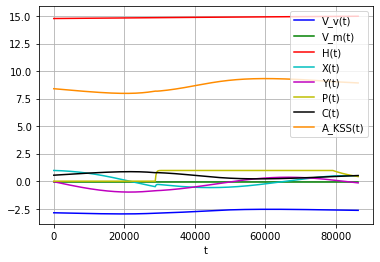

In [25]:
plt.plot(t, sol[:, 0], 'b', label='V_v(t)')
plt.plot(t, sol[:, 1], 'g', label='V_m(t)')
plt.plot(t, sol[:, 2], 'r', label='H(t)')
plt.plot(t, sol[:, 3], 'c', label='X(t)')
plt.plot(t, sol[:, 4], 'm', label='Y(t)')
plt.plot(t, sol[:, 5], 'y', label='P(t)')
plt.plot(t, C, 'k', label='C(t)')
plt.plot(t, A_KSS, 'darkorange', label='A_KSS(t)')
plt.legend(loc='best')
plt.xlabel('t')
#plt.xlim([200000,600000])
plt.grid()
plt.show()

In [72]:
#print(sol[800, 0])
#print(sol[800, 1])
#print(sol[800, 2])
#print(sol[800, 3])
#print(sol[800, 4])
#print(sol[800, 5])

-2.0554825647371104
-0.06999999999999974
15.327467373891183
-0.7005252668443381
0.6569957063182438
2.902936772591718e-21
